# Разные активы 

**Российский рынок**
- Сбербанк (SBER.ME)
- Газпром (GAZP.ME)
- ВТБ (VTBR.ME)
- Лукойл (LKOH.ME)

**Индексы**
- Индекс Московской биржи (IMOEX.ME)
- S&P500 (SPY)

**Американский рынок**
- Apple Inc. (AAPL)
- Exxon Mobil Corporation (XOM)
- Bank of America Corporation (BAC)

**Товары**
- Фьючерсы на пшеницу (Chicago SRW Wheat Futures, ZW=F))
- Фьючерсы на сою (Soybean Futures, ZS=F)
- Фьючерсы на нефть (Crude Oil, CL=F)

**Валюта**
- USD/RUB (RUB=X)
- USD/EUR (EUR=X)
- BTC/USD (BTC-USD)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import yfinance as yf

done:
- сделать два разных фора, для мультииндекса и нет
- построить графики для всех инструментов

todo:
- переделать добавление в общий датафрейм для одного инструмента

## Загрузка данных

In [2]:
start = '2010-01-01'
end = '2020-10-03'

In [3]:
assets = [
    'SBER.ME',
    'GAZP.ME',
    'VTBR.ME',
    'LKOH.ME',
    'IMOEX.ME',
    'SPY',
    'AAPL', 
    'XOM', 
    'BAC', 
    'ZW=F',
    'ZS=F',
    'CL=F',
    'RUB=X',
    'EUR=X',
    'BTC-USD'
]

In [4]:
df_m = yf.download(assets, start=start, end=end)

[*********************100%***********************]  15 of 15 completed


## Подготовка данных

In [5]:
def add_buy_and_sell(df):
    buy = df[['Close']].rename(columns={"Close": "Buy"})
    #buy['Buy'] = (df['Close']-df['Open'])/df['Open']
    buy['Buy'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)
    df = df.join(buy)

    sell = df[['Close']].rename(columns={"Close": "Sell"})
    #sell['Sell'] = (df['Open']-df['Close'])/df['Open']
    sell['Sell'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)
    df = df.join(sell)

    return df

In [6]:
df_m = add_buy_and_sell(df_m)

## Вспомогательные функции

In [7]:
def calc_n_days(values, n):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок или продаж.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день (или NaN)
    """
    if (values[:n] < 0).all():
        return values[-1]
    else:
        return np.nan

In [8]:
def calc_n_days_buysell(values, n):
    """Проверяет есть ли n дней подряд открытия или закрытия для покупок и продаж вместе.

    Args:
		values [list of float]: массив разницы в % между открытием и закрытие за n предыдущих дней
        n [int]: количество дней, за которые нужно проверять

	Returns:
		[float]: разница в % между открытием и закрытием за текущий день c учетом покупки или продажи (или NaN)
    """

    if (values[:n] < 0).all():
        return values[-1]
    elif (values[:n] > 0).all():
        return -1*values[-1]
    else:
        return np.nan

## Основной цикл для рассчёта

In [9]:
#много активов
def main_loop_m(df_m, start):
    if start != False:
        df_m = df_m[start:].copy(deep=True)
    for n in tqdm(range(1,6)):
        #n=4
        commission = 0.06

        buy_n_days = 'Buy_'+str(n)+'_Days'
        sell_n_days = 'Sell_'+str(n)+'_Days'
        buysell_n_days = 'Buysell_'+str(n)+'_Days'

        equity_buy_commiss = 'Equity_'+buy_n_days+'_Commiss'
        equity_sell_commiss = 'Equity_'+sell_n_days+'_Commiss'
        equity_buysell_commiss = 'Equity_'+buysell_n_days+'_Commiss'

        for asset in assets:
            buy_m = df_m[('Buy',asset)].dropna().rolling(n+1).apply(calc_n_days, args=(n,))
            sell_m = df_m[('Sell',asset)].dropna().rolling(n+1).apply(calc_n_days, args=(n,))    
            buysell_m = df_m[('Buy',asset)].dropna().rolling(n+1).apply(calc_n_days_buysell, args=(n,))

            #рассчет комиссии
            buy_commiss_m = (buy_m-commission/100*2).cumsum().apply(np.exp)
            sell_commiss_m = (sell_m-commission/100*2).cumsum().apply(np.exp)
            buysell_commiss_m = (buysell_m-commission/100*2).cumsum().apply(np.exp)  

            #добавление в общий датафрейм
            df_m[(equity_buy_commiss, asset)] = buy_commiss_m
            df_m[(equity_sell_commiss, asset)] = sell_commiss_m
            df_m[(equity_buysell_commiss, asset)] = buysell_commiss_m
    
    return df_m

In [10]:
df_m = main_loop_m(df_m, False)

## Графики

In [11]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

In [12]:
def draw(df_m, assets):
    for asset in assets:
        df_m[('Adj Close',asset)].interpolate(method='index').plot(figsize=(10,7), title=asset)
        plt.savefig('../src/'+asset.lower()+'.png')
        plt.show()
        plt.clf()

In [13]:
def draw_equity(df_m, assets, start):
    for asset in assets:
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        fig.suptitle(asset)
        for n in range(1,6):
            buy = 'Equity_Buy_'+str(n)+'_Days_Commiss'
            sell = 'Equity_Sell_'+str(n)+'_Days_Commiss'
            buysell = 'Equity_Buysell_'+str(n)+'_Days_Commiss'
            df_m[(buy,asset)].interpolate(method='index').plot(ax=ax[0], title='Buy', legend=False)
            df_m[(sell,asset)].interpolate(method='index').plot(ax=ax[1], title='Sell', legend=False)
            df_m[(buysell,asset)].interpolate(method='index').plot(ax=ax[2], title='Buysell', legend=True)
        plt.legend(loc='lower left')
        if start != False:
            plt.savefig('../src/'+asset.lower()+'_equity_'+start+'.png')
        else:
            plt.savefig('../src/'+asset.lower()+'_equity.png')
        plt.show()
        fig.clear()

### Российский рынок

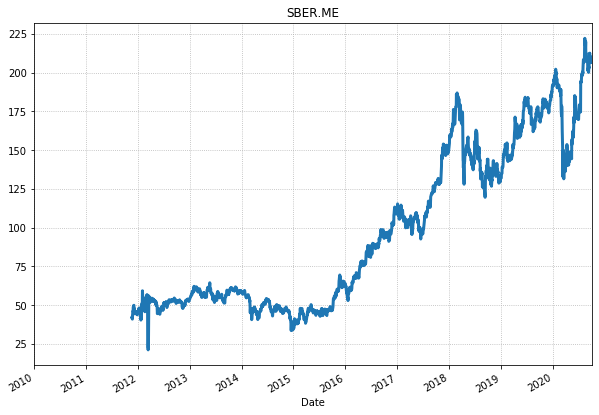

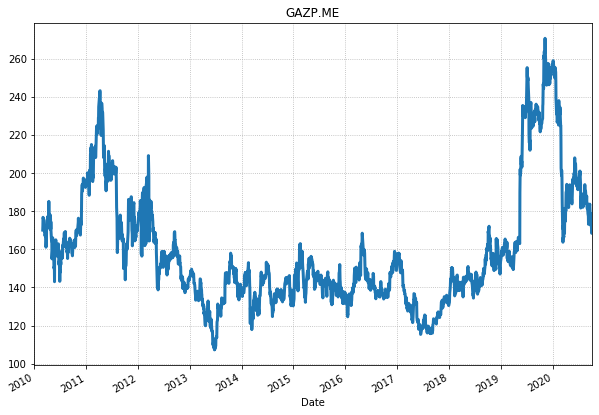

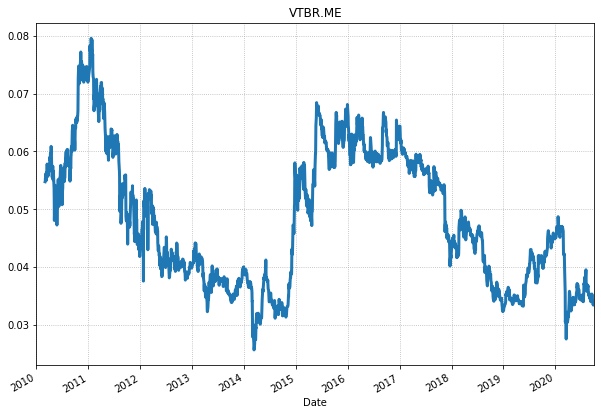

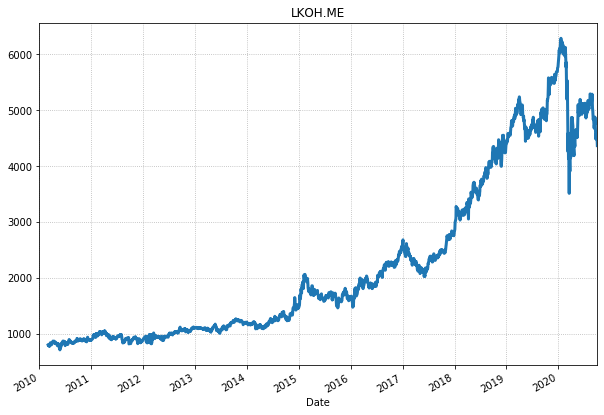

<Figure size 432x288 with 0 Axes>

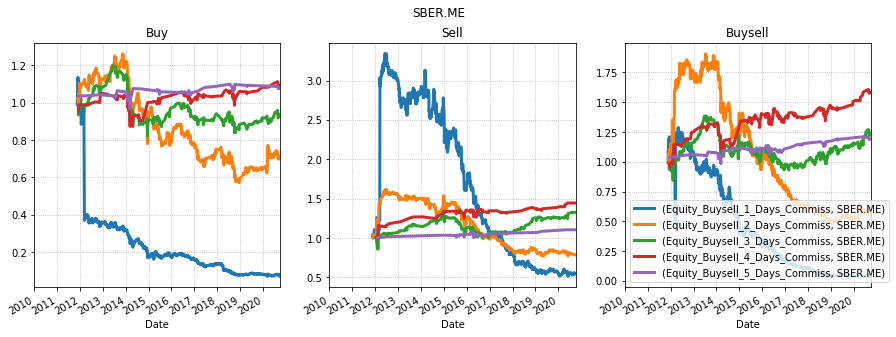

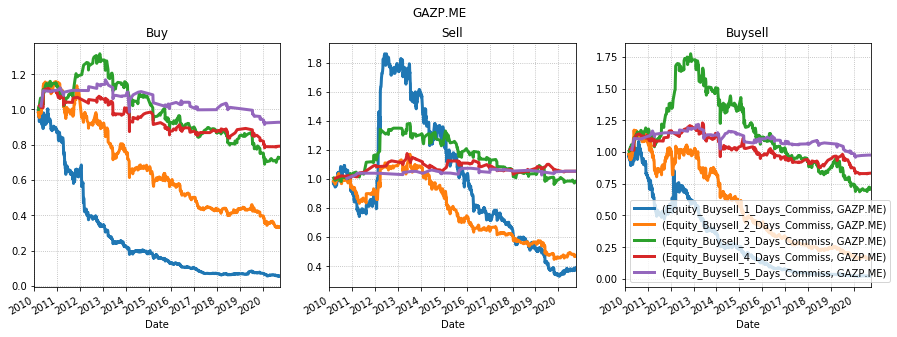

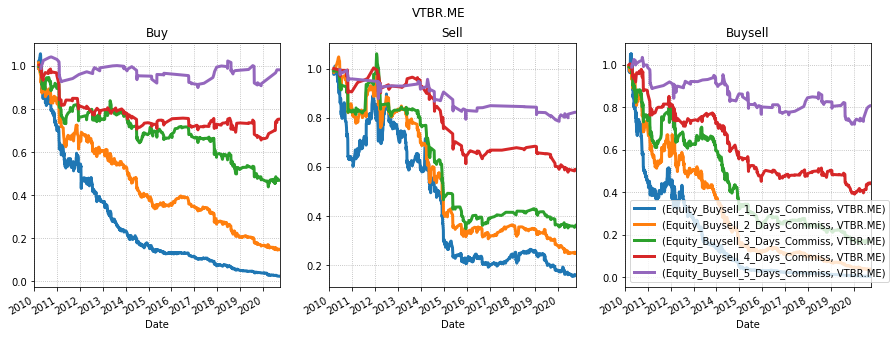

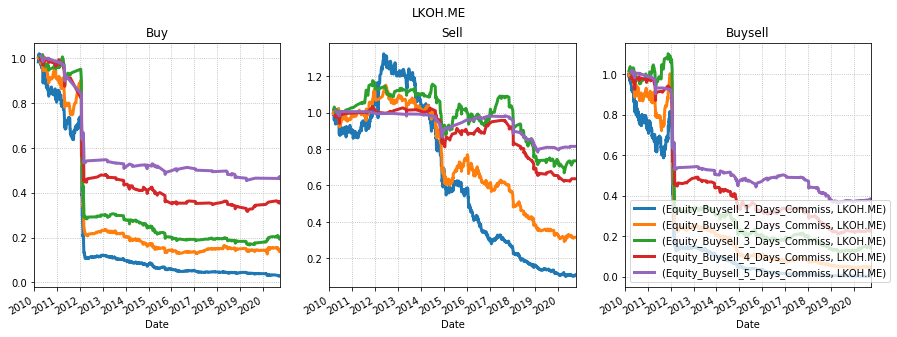

In [14]:
assets = [
    'SBER.ME',
    'GAZP.ME',
    'VTBR.ME',
    'LKOH.ME'
]
draw(df_m, assets)
draw_equity(df_m, assets, False)

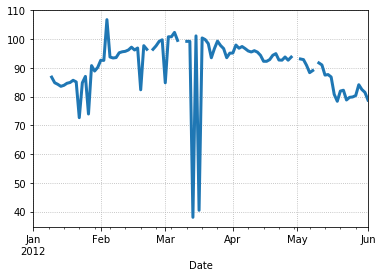

In [15]:
df_m['2012-01-01':'2012-06-01'][('Close','SBER.ME')].plot()
plt.savefig('../src/sber_2012.png')

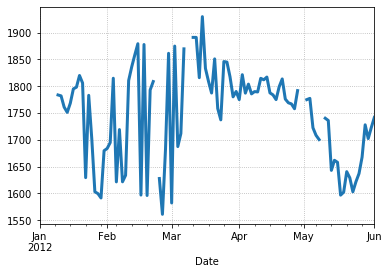

In [16]:
df_m['2012-01-01':'2012-06-01'][('Close','LKOH.ME')].plot()
plt.savefig('../src/lkoh_2012.png')

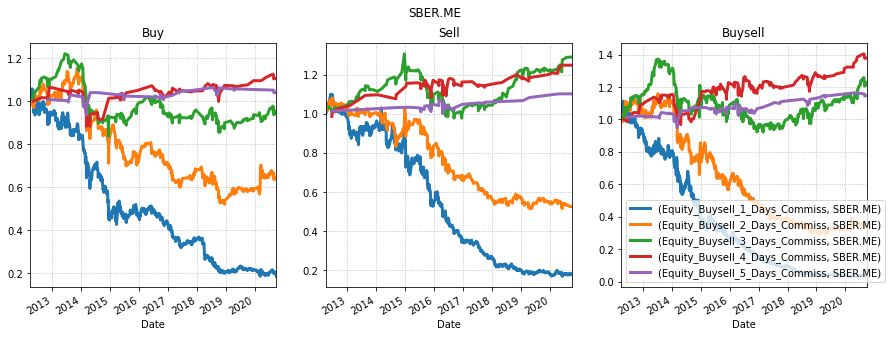

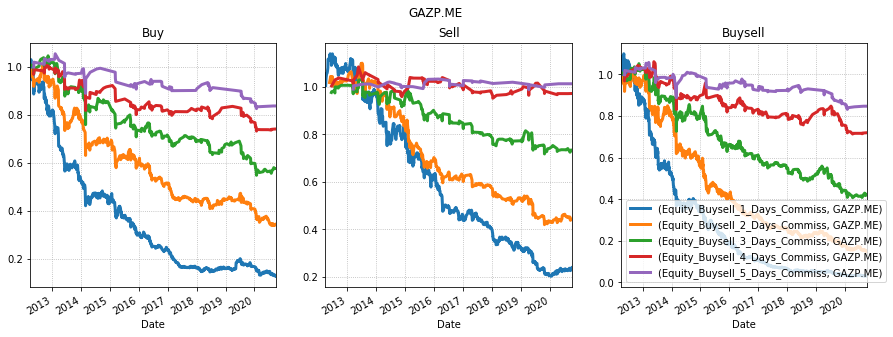

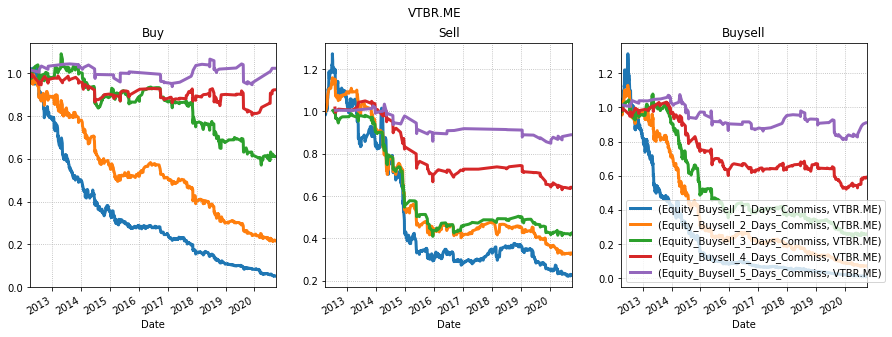

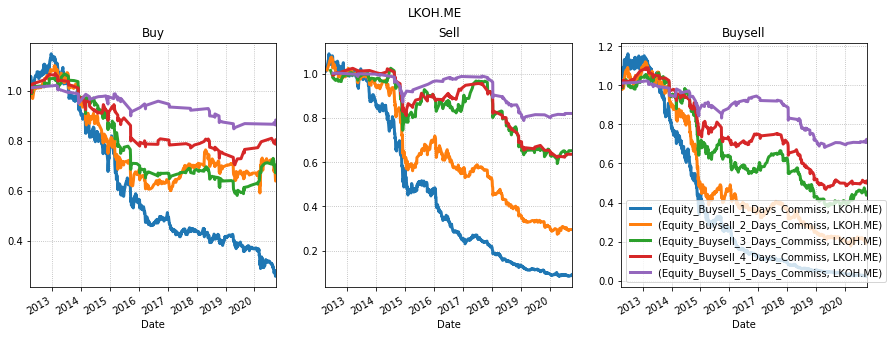

In [17]:
# стратовая дата с 2012-04-01
assets = [
    'SBER.ME',
    'GAZP.ME',
    'VTBR.ME',
    'LKOH.ME'
]
df_m_2012 = main_loop_m(df_m, start='2012-04-01')
draw_equity(df_m_2012, assets, start)

### Индексы

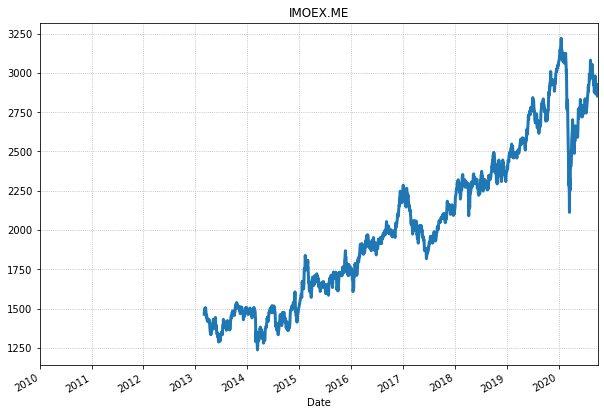

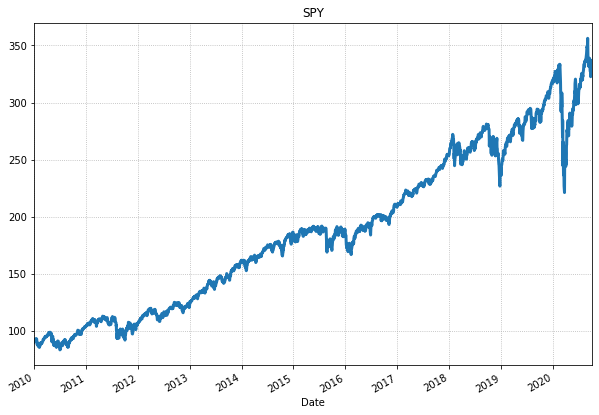

<Figure size 432x288 with 0 Axes>

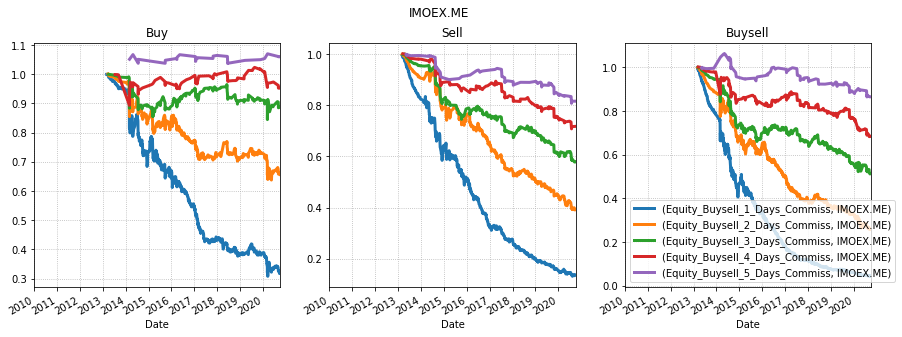

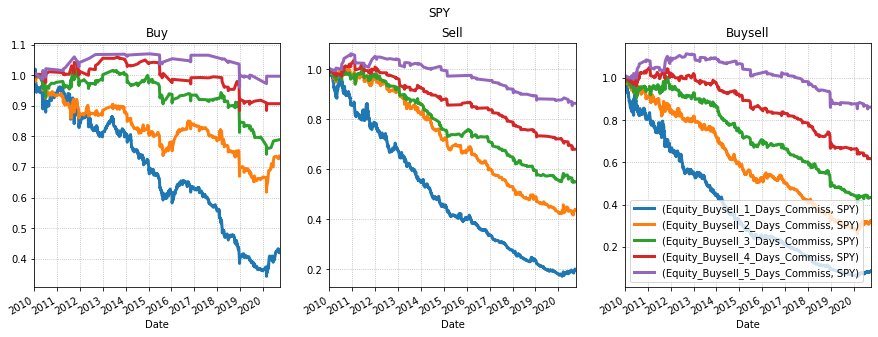

In [18]:
assets = [
    'IMOEX.ME',
    'SPY'
]
draw(df_m, assets)
draw_equity(df_m, assets, False)

### Американский рынок

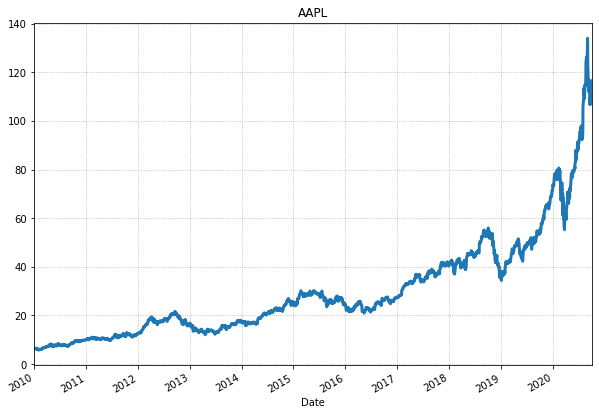

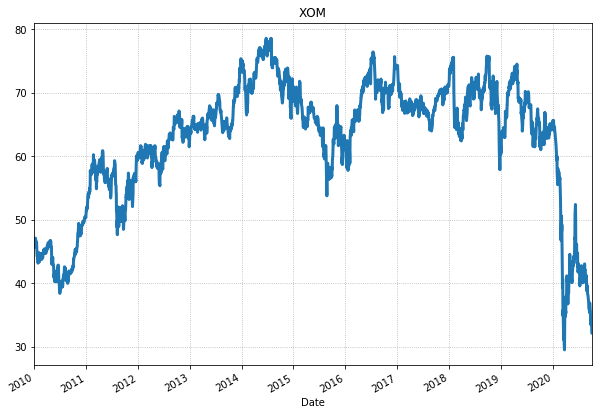

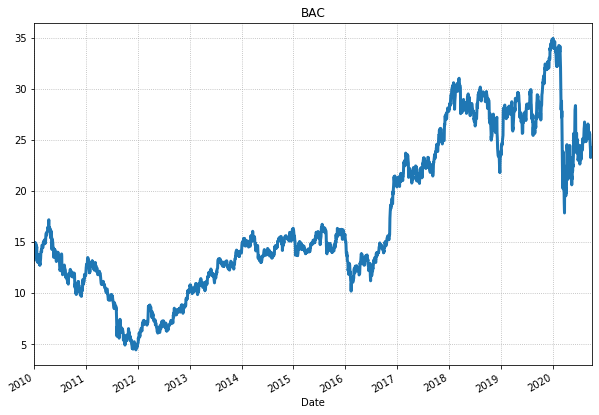

<Figure size 432x288 with 0 Axes>

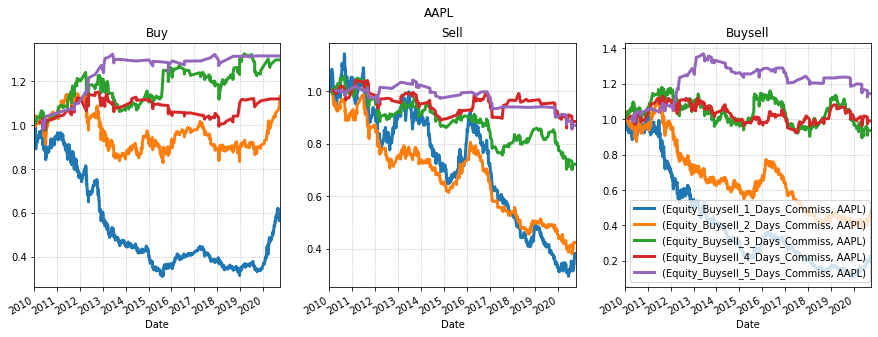

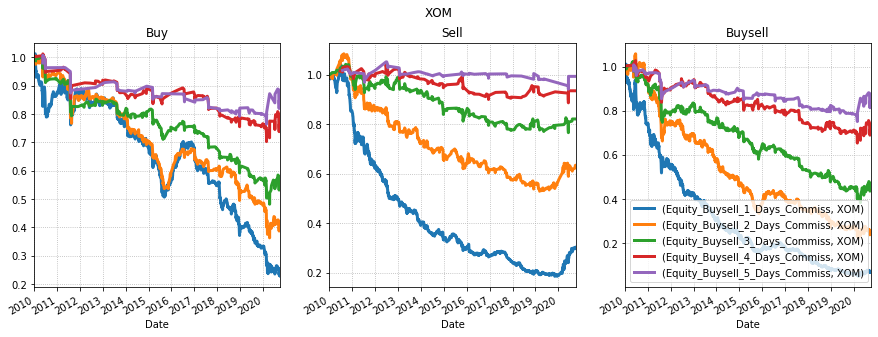

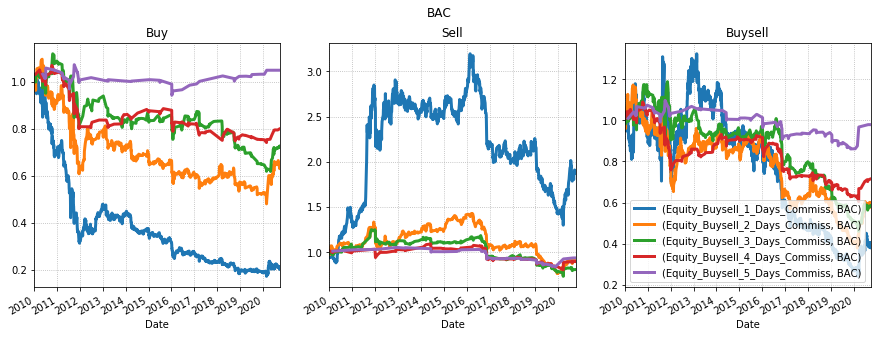

In [19]:
assets = [
    'AAPL', 
    'XOM', 
    'BAC' 
]
draw(df_m, assets)
draw_equity(df_m, assets, False)

### Товары

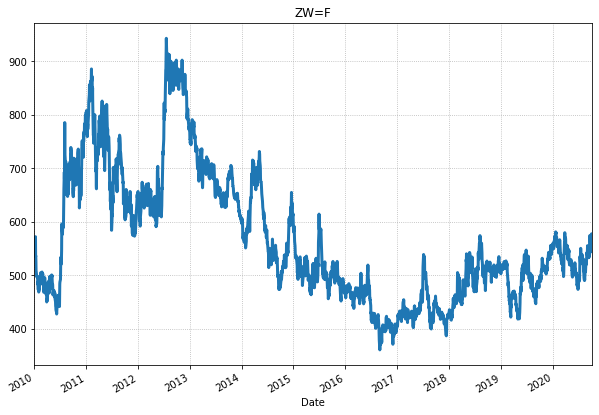

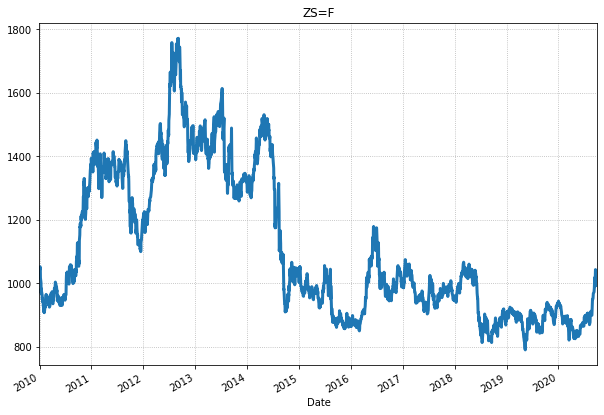

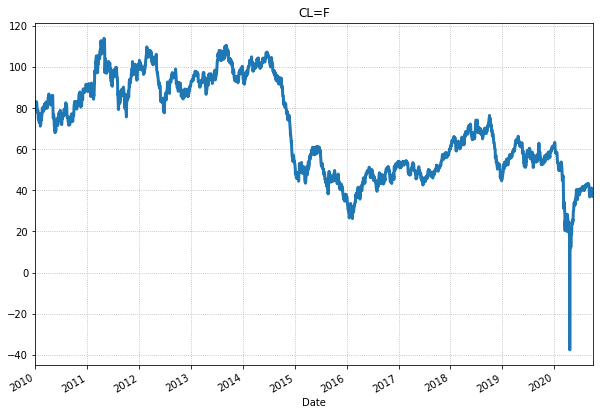

<Figure size 432x288 with 0 Axes>

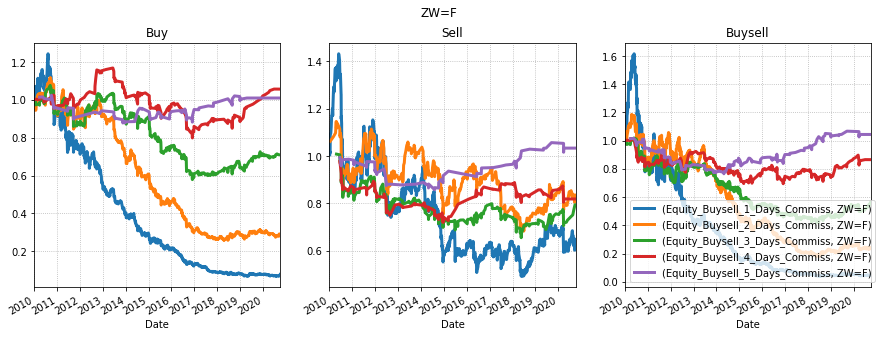

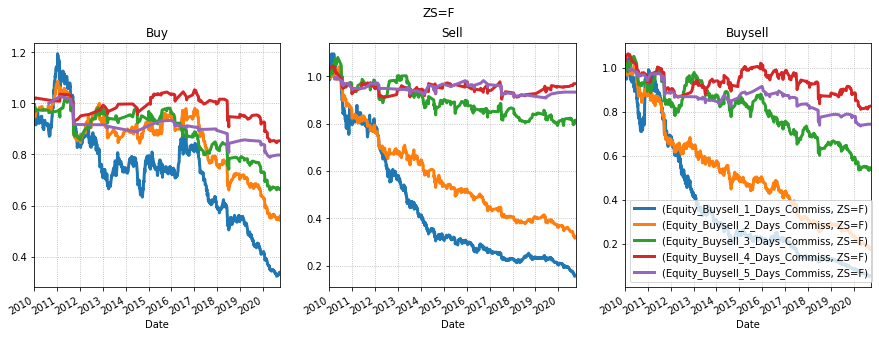

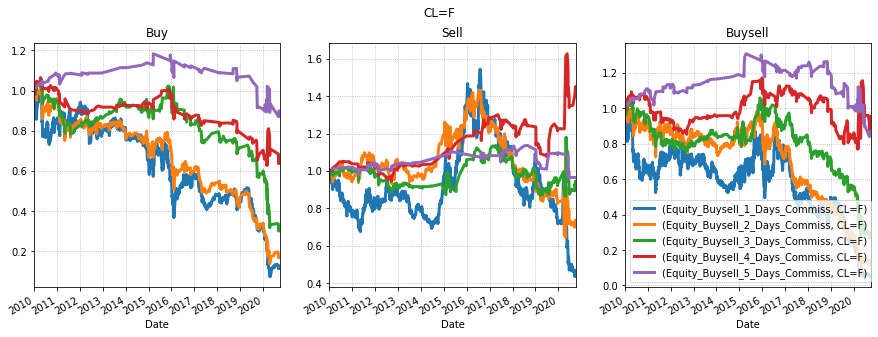

In [20]:
assets = [
    'ZW=F',
    'ZS=F',
    'CL=F'
]
draw(df_m, assets)
draw_equity(df_m, assets, False)

### Валюты

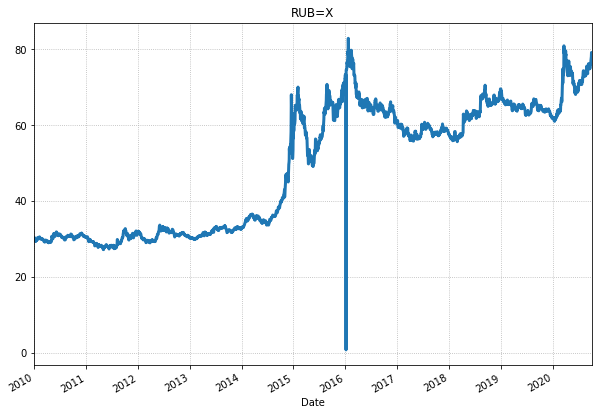

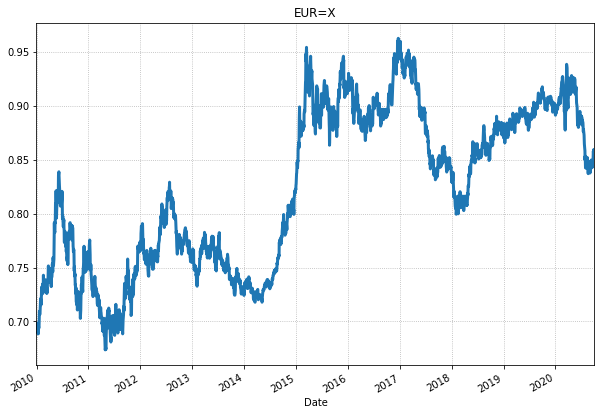

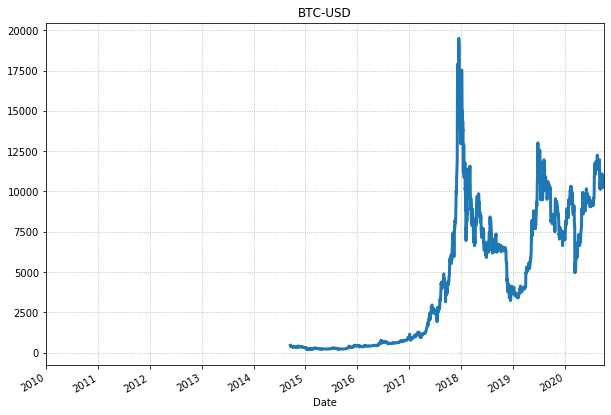

<Figure size 432x288 with 0 Axes>

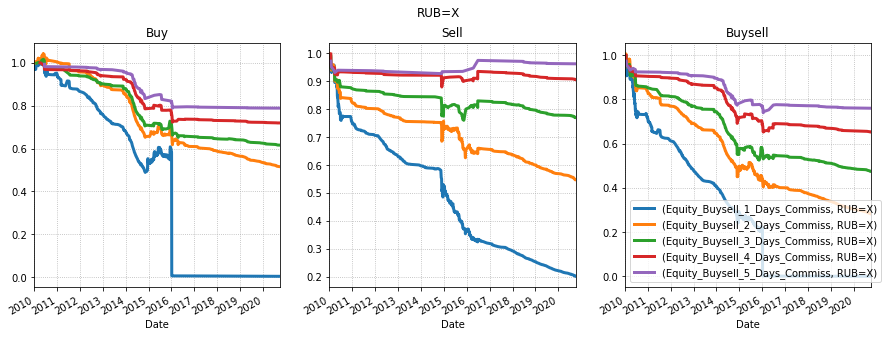

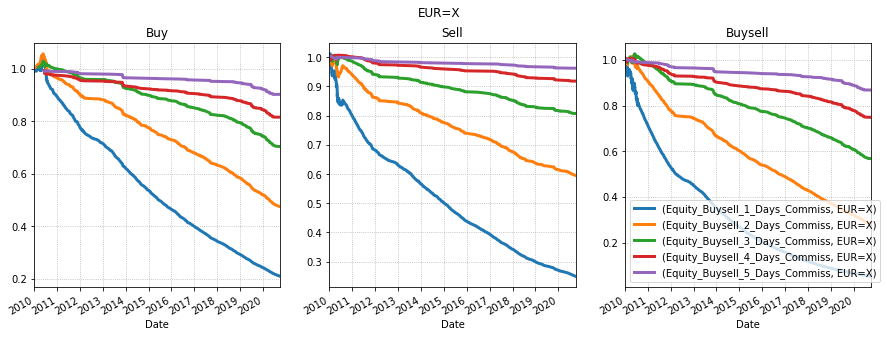

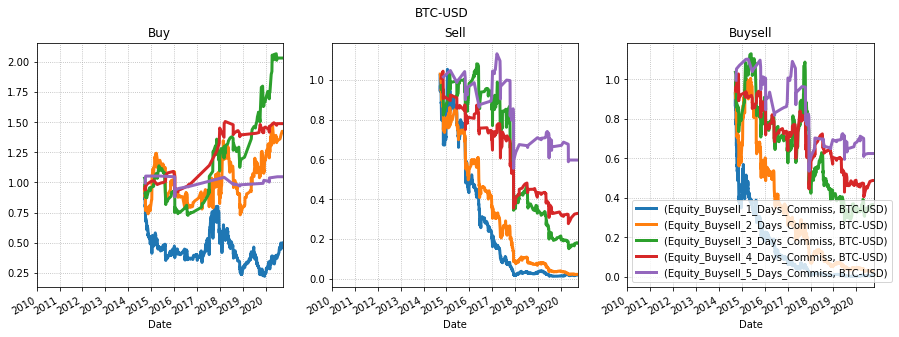

In [21]:
assets = [
    'RUB=X',
    'EUR=X',
    'BTC-USD'
]
draw(df_m, assets)
draw_equity(df_m, assets, False)